In [1]:
# Imports from SCSF module
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import CONFIG1
# Standard Imports
import s3fs             # AWS-S3 connectivity for pandas
import pandas as pd
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from cvxpy import SolverError
# Environment Setup
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

This is a helper function for loading data from the S3 bucket. The metadata file is cached locally for speed. This function enforces a regular time axis on each file as it is downloaded. That is, a time axis will be established that has exactly 288 values per day (5-minute data). Then the data will be realigned to that axis, with gaps being filled with zero values. I have also written a helper function to do this with PVDAQ queries, which you can find here: https://github.com/bmeyers/pvdaqQuery/

In [2]:
def load_sys(n=None, idnum=None, base='s3://pvinsight.nrel/PVO/'):
    """
    If idnum kwarg is specified, it overwrites any user defined value in the n kwarg.
    
    :param n: The index of the sequential ordering of the systems in the metadata file
    :param idnum: The system ID number
    """

    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    if n is not None:
        idnum = meta['ID'][n]
    elif idnum is not None:
        n = meta[meta['ID'] == idnum].index[0]
    else:
        print('must provide index or ID')
        return
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(idnum), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, idnum)
    return df

In [3]:
n = 572#np.random.randint(642)
idnum = 31195
df = load_sys(idnum=idnum)

326 31195


Determine the first and last full days of data in the data set.

In [4]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2015-02-16 2017-07-30


In [5]:
end - start

Timedelta('895 days 00:00:00')

Format the (1D) timeseries power data into a (2D) matrix, with each column containing one day of data. If you take the column sums of this matrix, you get the total energy produced by the PV system on each day (to within a multiplicative constant).

In [6]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')

## Using the Statistical Clear Sky class

The class is called `IterativeClearSky` to differentiate it from other, early versions of this approach. This naming convention may be subject to change. The only necessary input is a day-aligned timeseries data matrix, `D`. By default, the Generalized Low Rank Model (http://web.stanford.edu/~boyd/papers/glrm.html) has a rank $k=4$. This can be changed by setting the `k` keyword argument.

The initialization of the class automatically detects time shift issues and will correct for them. We can check the `fixedTimeStamps` flag to see if this has occured.

In [7]:
ics = IterativeClearSky(D)
ics.fixedTimeStamps

False

Next we run through some built-in plotting function for the class. First up, the power viewed as an image. Sunrise is on the top and sunset is on the bottom. the tick marks on the bottom indicate days identified by the class as likely being clear or sunny days.

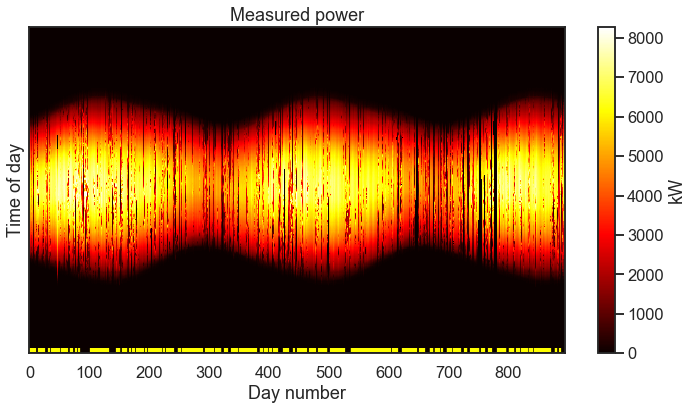

In [8]:
_ = ics.plot_D(show_days=True)

Next we look at the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of the data matrix `D`. (Here, I've scaled the right singular vectors by the singular values.) These are used as initialization data for the iterative algorithm. On the right are columns (or day) identified by the algorithm as being clear, corresponding with the tick marks above.

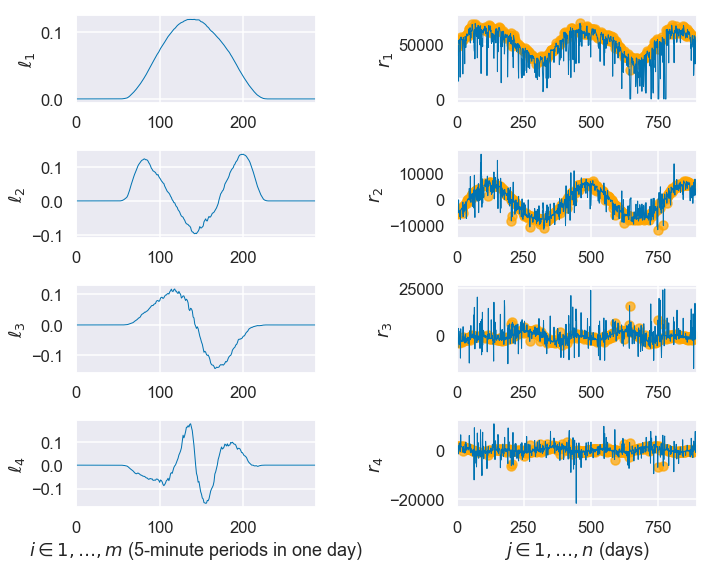

In [9]:
_ = ics.plot_singular_vectors(show_days=True)

Finally, we look at the daily energy output of the system. Possibly clear days are again identified by orange markers.

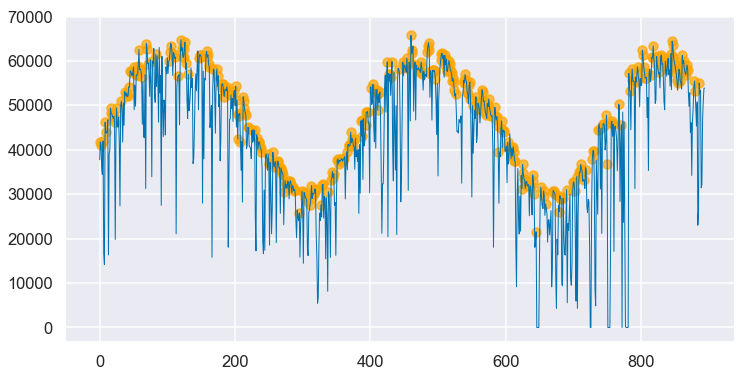

In [10]:
_ = ics.plot_energy()

Next, we run the actual SCSF algorithm. The configuration parameters passed to the method set some regularization weights and tolerances.

In [11]:
ics.minimize_objective(**CONFIG1)

starting at 870854323.200 [4061167.4411352, 698.8616648408832, 687251952.4067919, 179540504.49003544]
iteration 1: 2607070.676 [2.42970238e+06 3.92851000e+02 1.76975397e+05 4.70000000e-02]
iteration 2: 2067341.282 [1.88083341e+06 1.19164200e+03 1.85316154e+05 7.40000000e-02]
iteration 3: 1994595.925 [1.80552518e+06 1.21138000e+03 1.87859347e+05 1.90000000e-02]
iteration 4: 1974151.698 [1.78423819e+06 1.26497100e+03 1.88648531e+05 8.00000000e-03]
iteration 5: 1966212.141 [1.77593950e+06 1.32613200e+03 1.88946415e+05 9.90000000e-02]
Minimization complete in 1.57 minutes


The class records some high level feedback on how the algorithm performed. If the residual metrics are too high, that is usually a bad sign. Likewise if any of the flags are `True`.

In [12]:
print(np.round((
    ics.residuals_median,
    ics.residuals_variance,
    ics.residual_l0_norm
), 3), ics.isProblemStatusError, ics.isSolverError, ics.f1Increase, ics.objIncrease)

[0.094 0.011 0.059] False False False False


Here is the estimated degradation rate (year on year energy-yield) for the system:

In [13]:
ics.beta.value

array(-0.0187217)

We can view the GLRM factorization (this is the factorized form of our clear sky estimate).

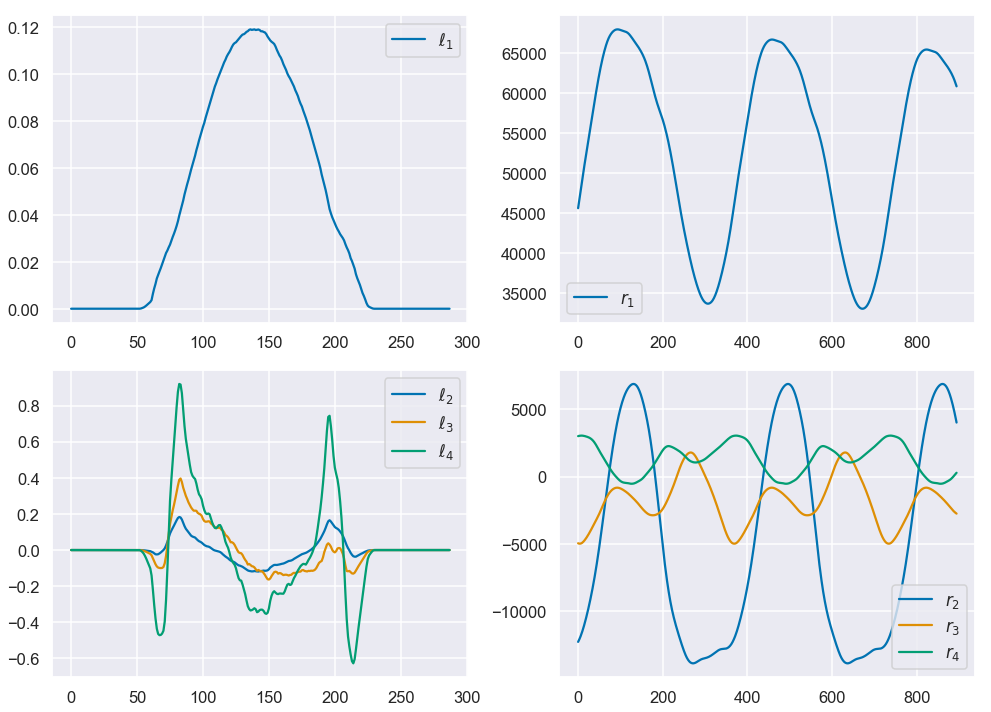

In [14]:
_ = ics.plot_LR()

And we can compare the original data to the estimated clear sky data.

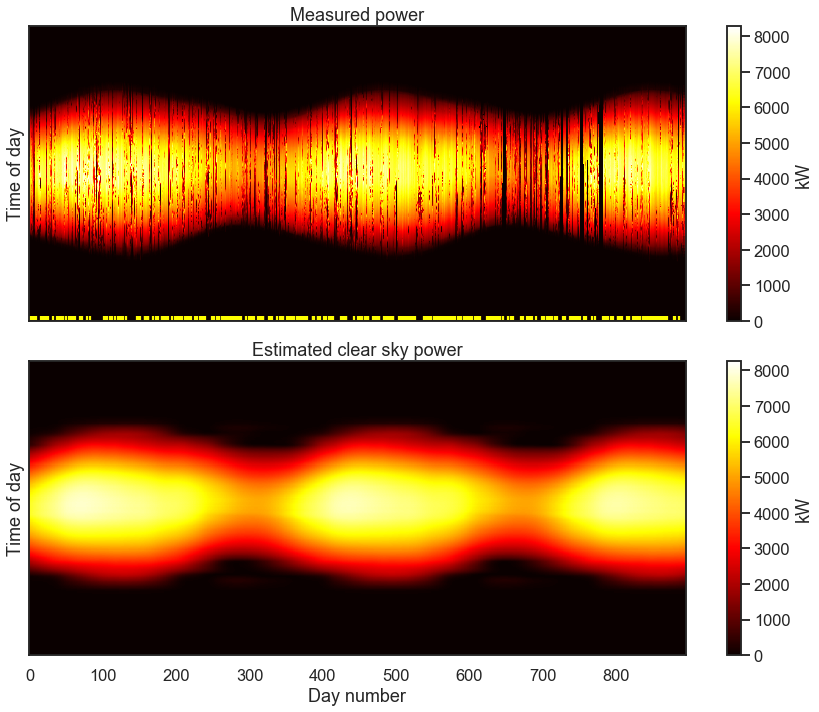

In [15]:
_ = ics.plot_measured_clear(figsize=(12, 10), show_days=True)

There are also a couple traditional timeseries views.

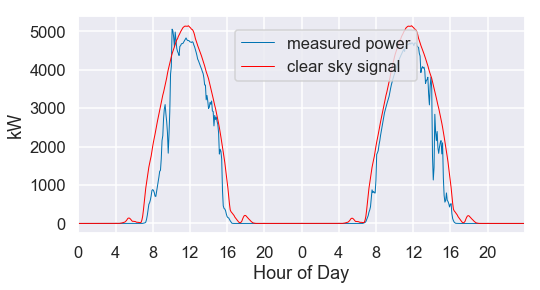

In [16]:
_ = ics.ts_plot(309)

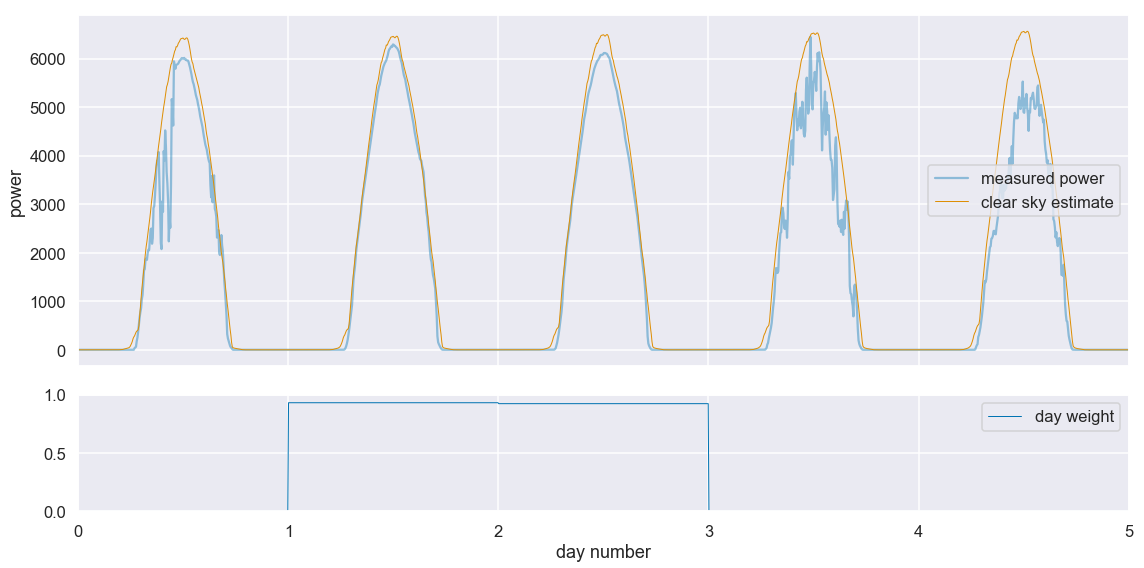

In [17]:
_ = ics.ts_plot_with_weights(250)

Looking at the daily energy plot again, we can now overlay estimated clear sky daily energy as well.

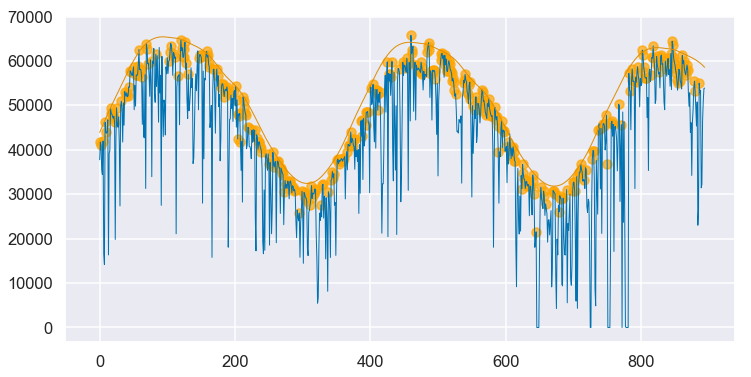

In [18]:
_ = ics.plot_energy(show_clear=True)

## Comparison to a low-pass image filter

Below, we take a look at the 2D Fourier Transform of the raw timeseries data, viewed as an image. There's period structure in both vertical and horizontal axes of the image, so we expect to see strong spectra along both axes of the transformed image.

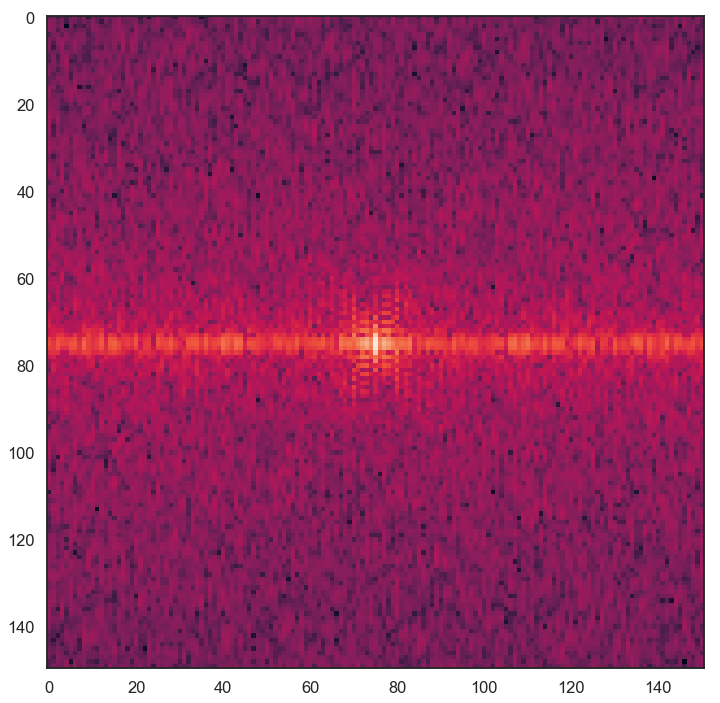

In [19]:
FS = fft2(D)
with sns.axes_style("white"):
    m, n = D.shape
    i = int(m / 2 - 75)
    j = int(n / 2 - 75)
    plt.figure(figsize=(12,12))
    plt.imshow(np.log(np.abs(np.fft.fftshift(FS)[i:-i, j:-j])**2))

Next, design a simple low-pass filter: a circle-shaped pillbox aligned with the center of the transformed image. This is applied to the tranformed image, removing all information outside that circle. This is then passed through the Inverse 2D Fourier Transform to get a low-pass filter of the original data.

In [20]:
fltr = np.zeros_like(D, dtype=np.float)
m, n = D.shape
c = (m // 2, n // 2)
r = 25
if m % 2 == 0:
    di = 0
else:
    di = 1
if n % 2 == 0:
    dj = 0
else:
    dj = 1
y, x = np.ogrid[-c[0]:c[0]+di, -c[1]:c[1]+dj]
mask = x ** 2 + y ** 2 <= r ** 2
fltr[mask] = 1
FS_filtered = fftshift(np.multiply(fftshift(FS), fltr))
D_filtered = np.abs(ifft2(FS_filtered))

Finally, we can view the 2D, low-pass filtered power data. This does not make an adequate clear sky model.

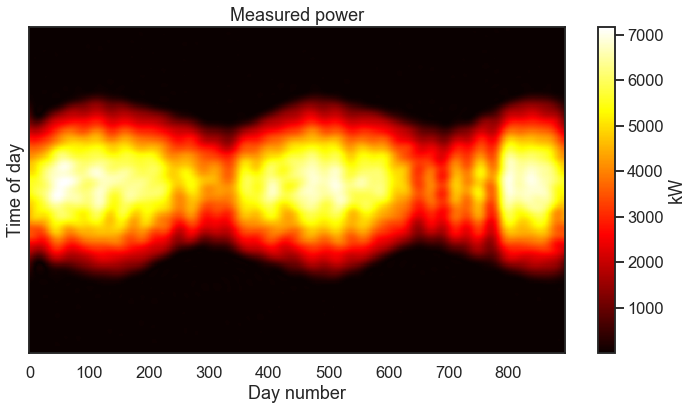

In [21]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(D_filtered, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

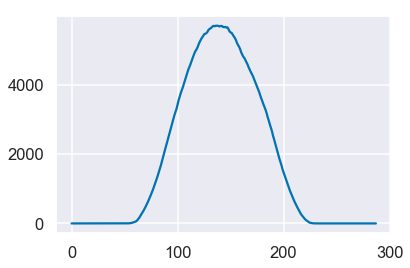

In [24]:
plt.plot(np.average(ics.D, axis=1))